In [116]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# Part One: Data Exploration


In [117]:
url1 = "https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1"
df = pd.read_csv(url1)

print(df.head())

   age     sex     bmi smoker     region      charges
0   19  female  27.900    yes  southwest  16884.92400
1   33    male  22.705     no  northwest  21984.47061
2   32    male  28.880     no  northwest   3866.85520
3   31  female  25.740     no  southeast   3756.62160
4   60  female  25.840     no  northwest  28923.13692


In [118]:
print(df.dtypes)

age          int64
sex         object
bmi        float64
smoker      object
region      object
charges    float64
dtype: object


In [119]:
print(df.describe())


              age         bmi       charges
count  431.000000  431.000000    431.000000
mean    37.960557   30.768898  12297.098118
std     16.363909    6.111362  11876.527128
min     18.000000   15.960000   1131.506600
25%     22.000000   26.357500   2710.444575
50%     34.000000   30.590000   9866.304850
75%     55.000000   35.272500  14510.872600
max     64.000000   49.060000  55135.402090


In [120]:
print(df.nunique())

age         47
sex          2
bmi        305
smoker       2
region       4
charges    430
dtype: int64


In [121]:
print(len(df))
df = df.dropna()
print(len(df))

431
431


In [122]:
import plotnine as p9
p1 = (
    p9.ggplot(df, p9.aes(x="age", y="charges")) +
    p9.geom_point(alpha=0.5) +
    p9.geom_smooth(method="lm", color="blue") +
    p9.labs(title="Charges vs Age", x="Age", y="Charges")
)


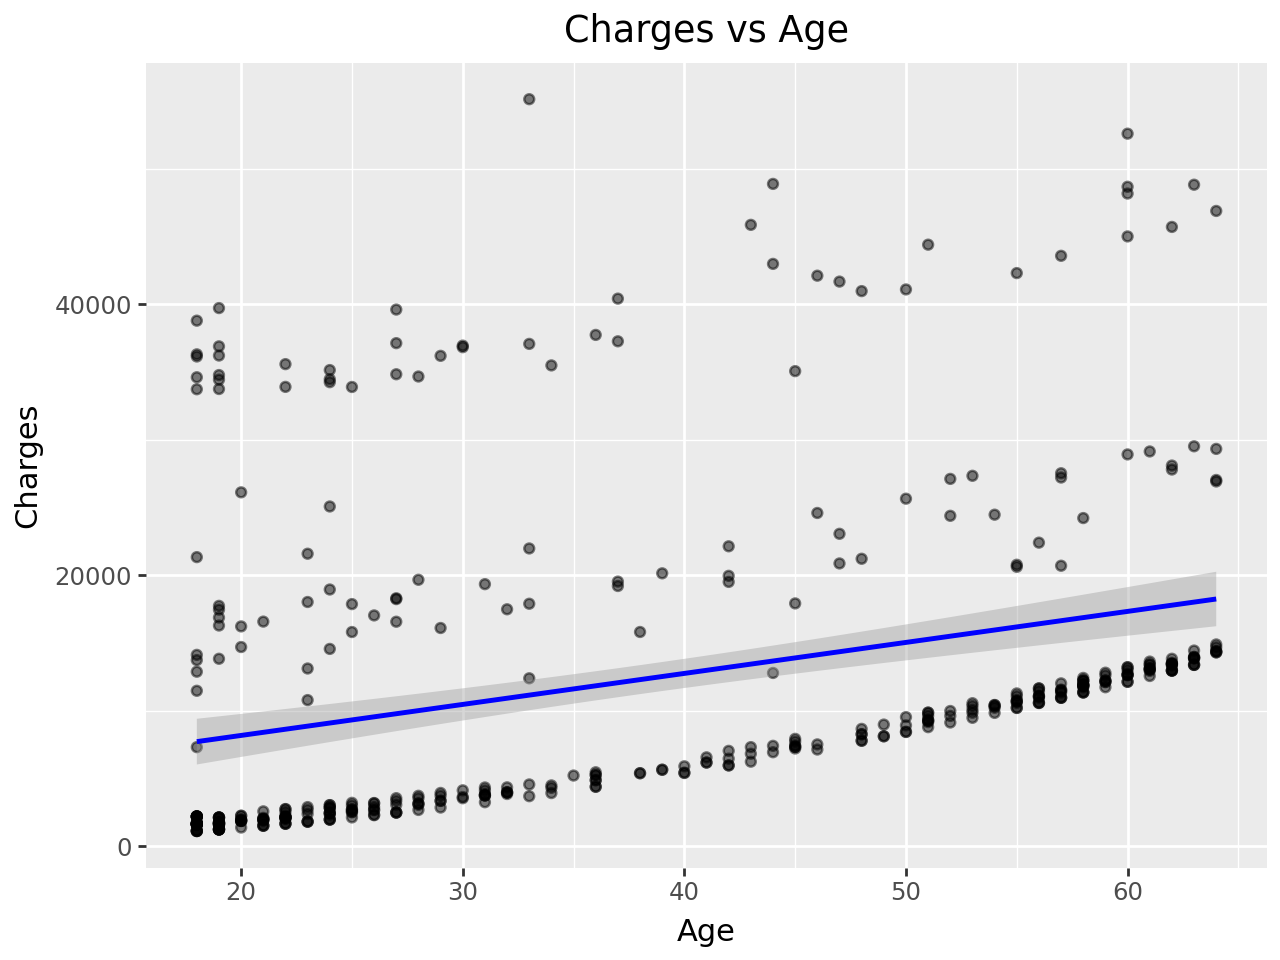

In [123]:
p1.show()

The first plot shows a positive relationship between age and insurance charges.
As the age of the beneficiary increases, the average insurance cost tends to rise.
However, there is noticeable variability—especially among older individuals—suggesting that other factors (like smoking or BMI) also affect costs.

In [124]:
p2 = (
    p9.ggplot(df, p9.aes(x="bmi", y="charges")) +
    p9.geom_point(alpha=0.5) +
    p9.geom_smooth(method="lm", color="darkgreen") +
    p9.labs(title="Charges vs BMI", x="BMI", y="Charges")
)

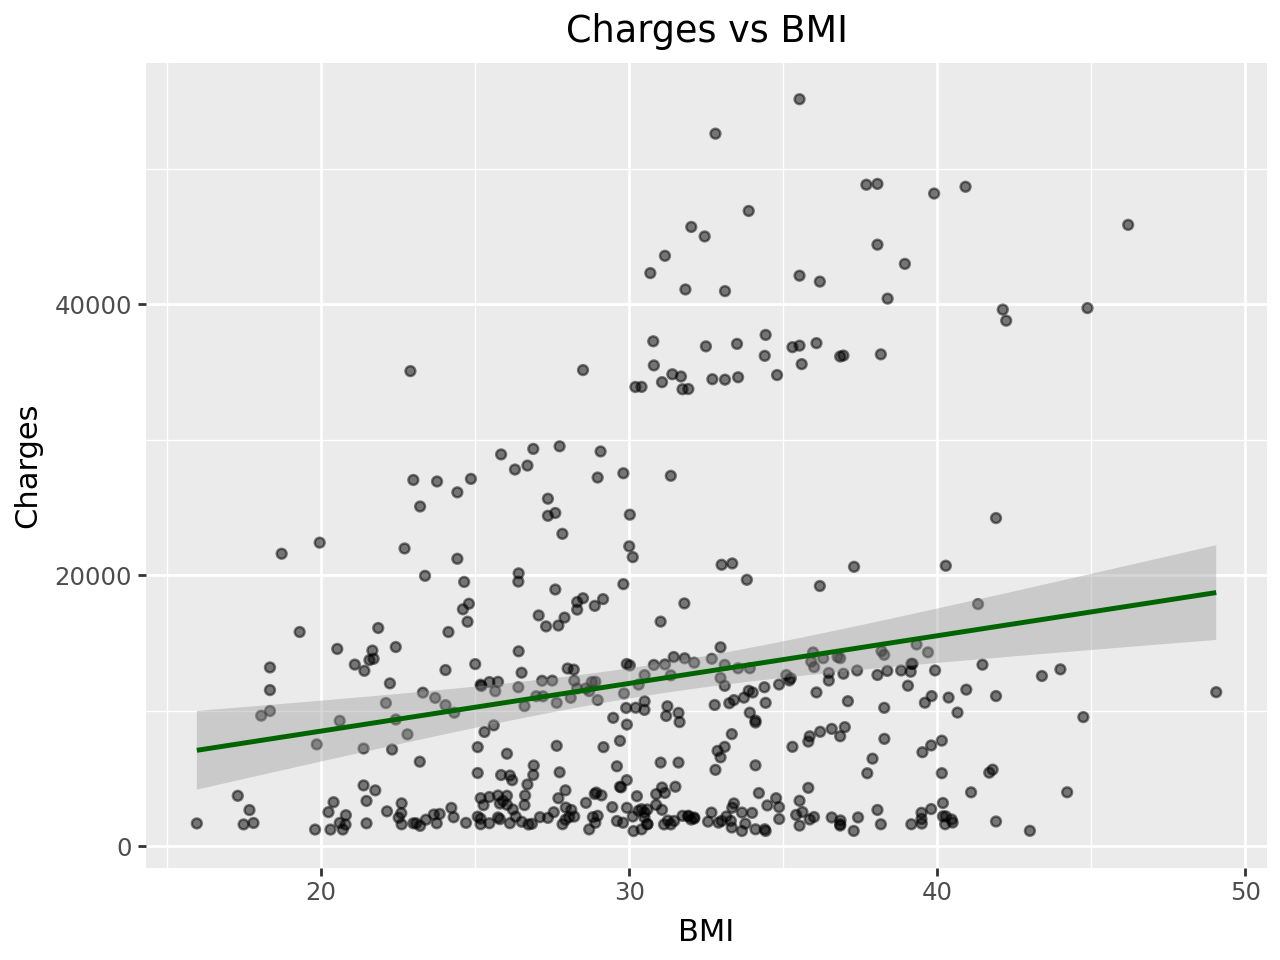

In [125]:
p2.show()

The plot indicates a weak positive trend between BMI and charges.
Individuals with higher BMI values often have slightly higher insurance costs, but the relationship is more scattered.
There are several outliers—people with very high BMI and charges—which may reflect higher health risks.

In [126]:
p3 = (
    p9.ggplot(df, p9.aes(x="smoker", y="charges", fill="smoker")) +
    p9.geom_boxplot() +
    p9.labs(title="Charges vs Smoker Status", x="Smoker", y="Charges")
)

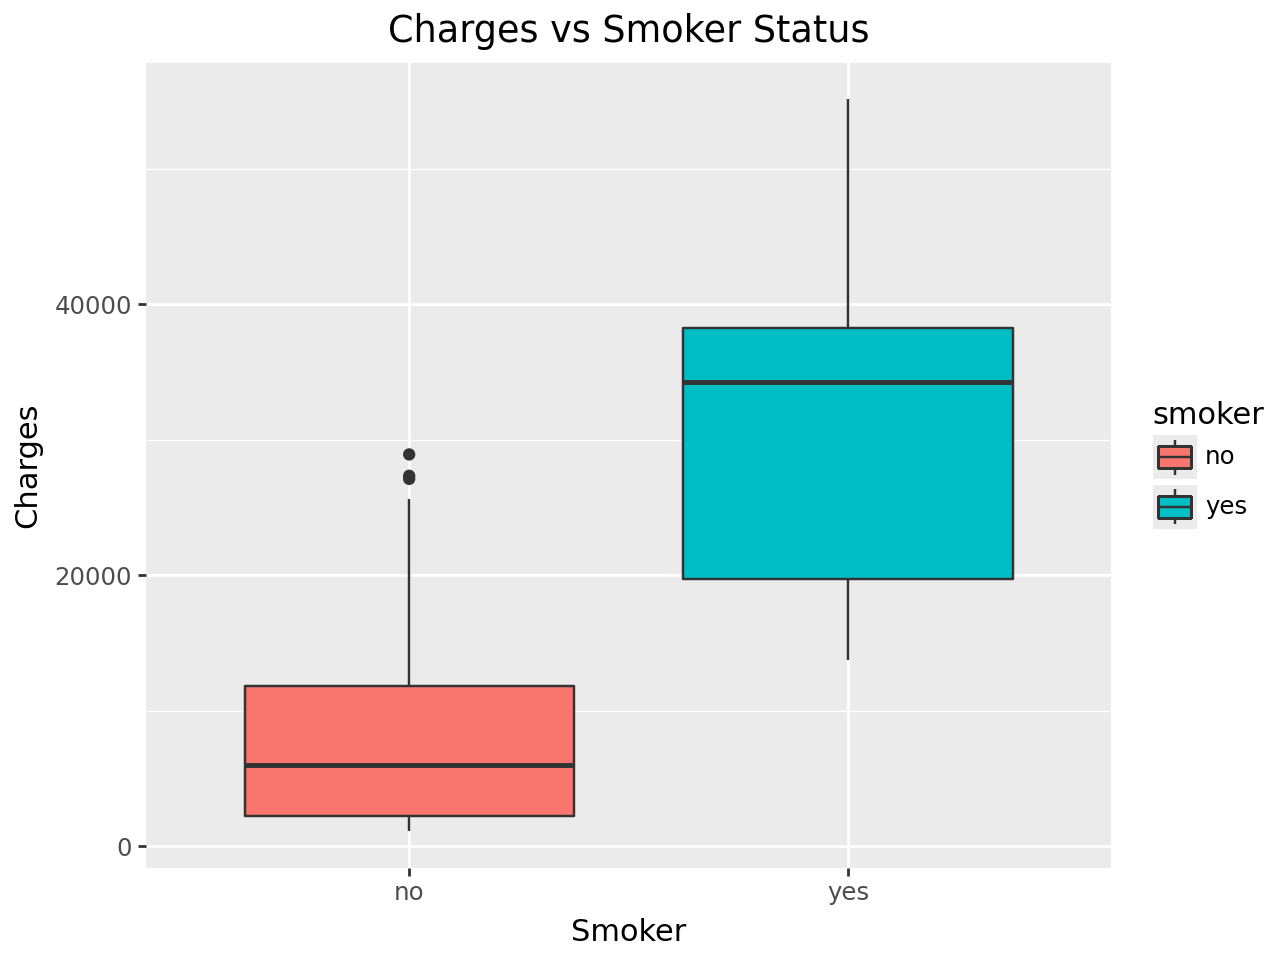

In [127]:
p3.show()

The plot shows a clear and strong difference between smokers and non-smokers.
Smokers’ median and overall insurance charges are much higher than those of non-smokers.
This suggests that smoking is likely a major driver of insurance costs and will be an important variable in the modeling phase.

# Part Two: Simple Linear Models

### Models: age, age + sex, age + smoker

In [128]:
y = df["charges"]

1. Construct a simple linear model to predict the insurance charges from the beneficiary’s age. Discuss the model fit, and interpret the coefficient estimates.

In [129]:
X_age = df[["age"]]
X_train, X_test, y_train, y_test = train_test_split(X_age,y)
m1 = LinearRegression().fit(X_train, y_train)
yhat1 = m1.predict(X_test)
mse1 = mean_squared_error(y_test, yhat1)
r2_1 = r2_score(y_test, yhat1)
print(f"Model 1 (age): MSE={mse1}, R²={r2_1}")


Model 1 (age): MSE=109743299.71329679, R²=0.096661659355475


2. Make a model that also incorporates the variable sex. Report your results.

In [130]:
ct_sex = ColumnTransformer([
    ("num", "passthrough", ["age"]),
    ("cat", OneHotEncoder(drop="first"), ["sex"])
])
X2 = df[["age","sex"]]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y)

pipe2 = Pipeline([("ct", ct_sex), ("lr", LinearRegression())])
pipe2.fit(X_train2, y_train2)
yhat2 = pipe2.predict(X_test2)
mse2 = mean_squared_error(y_test2, yhat2)
r2_2 = r2_score(y_test2, yhat2)
print(f"Model 2 (age + sex): MSE={mse2}, R²={r2_2}")

Model 2 (age + sex): MSE=144477850.07289356, R²=0.12443242691377732


3. Now make a model that does not include sex, but does include smoker. Report your results.

In [131]:
ct_smoker = ColumnTransformer([
    ("num", "passthrough", ["age"]),
    ("cat", OneHotEncoder(drop="first"), ["smoker"])
])

X3 = df[["age", "smoker"]]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y)

pipe3 = Pipeline([("ct", ct_smoker), ("lr", LinearRegression())])
pipe3.fit(X_train3, y_train3)
yhat3 = pipe3.predict(X_test3)
mse3 = mean_squared_error(y_test3, yhat3)
r2_3 = r2_score(y_test3, yhat3)
print(f"Model 3 (age + smoker): MSE={mse3}, R²={r2_3}")

Model 3 (age + smoker): MSE=35109213.73279115, R²=0.7366822385826561


4. Which model (Q2 or Q3) do you think better fits the data? Justify your answer by calculating the MSE for each model, and also by comparing R-squared values.

* The age + smoker model has a much lower Mean Squared Error (MSE) and a much higher R².

* This demonstrates that smoking status is a far more powerful predictor of insurance costs than gender

# Part Three: Multiple Linear Models

Model: $age + bmi, age^2, age^4, age^{12}$

1. Fit a model that uses age and bmi as predictors. (Do not include an interaction term, age*bmi, between these two.) Report your results. How does the MSE compare to the model in Part Two Q1? How does the R-squared compare?

In [132]:
X_ab = df[["age","bmi"]]
X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(X_ab,y)
m_ab = LinearRegression().fit(X_train_ab, y_train_ab)
yhat_ab = m_ab.predict(X_test_ab)
mse_ab = mean_squared_error(y_test_ab, yhat_ab)
r2_ab = r2_score(y_test_ab, yhat_ab)
print(f"age + bmi: MSE={mse_ab}, R²={r2_ab}")

age + bmi: MSE=104691665.44241251, R²=0.06906459564174217


2. Perhaps the relationships are not linear. Fit a model that uses age and age^2 as predictors. How do the MSE and R-squared compare to the model in P2 Q1?
3. Fit a polynomial model of degree 4. How do the MSE and R-squared compare to the model in P2 Q1?
4. Fit a polynomial model of degree 12. How do the MSE and R-squared compare to the model in P2 Q1?

In [133]:
X = df[["age"]]
def poly_model(degree):
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Transform features into polynomial terms
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Fit linear regression model
        model = LinearRegression().fit(X_train_poly, y_train)

        # Predict on test data
        preds = model.predict(X_test_poly)

        # Evaluate test performance
        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        return mse, r2, model

for deg in [2, 4, 12]:
    mse, r2, _ = poly_model(deg)
    print(f"Polynomial degree {deg}: MSE={mse}, R²={r2}")

Polynomial degree 2: MSE=140964723.05883405, R²=0.1291429028698895
Polynomial degree 4: MSE=138845451.48749572, R²=0.14223541742671075
Polynomial degree 12: MSE=141311201.57461622, R²=0.12700241503772403


5. According to the MSE and R-squared, which is the best model? Do you agree that this is indeed the “best” model? Why or why not?

Based on MSE and R², the age + BMI model performs slightly better than the polynomial models.
It has the lowest MSE (≈123.8 million) and the highest R² (≈0.12) among the tested models.

For $age^2$ model: Slight improvement vs. age-only, but not as good as including BMI. The curve captures mild nonlinearity.

For $age^{12}$ model: Overfitting begins — model becomes too complex and generalization suffers.

6. Plot the predictions from your model in Q4 as a line plot on top of the scatterplot of your original data.

In [134]:
degree = 12
mse, r2, model = poly_model(degree)
poly = PolynomialFeatures(degree=degree, include_bias=False)
poly.fit(X)

age_range = np.linspace(df["age"].min(), df["age"].max(), 200).reshape(-1, 1)
age_poly = poly.transform(age_range)
charges_pred = model.predict(age_poly)

plot_df = pd.DataFrame({
    "age": age_range.flatten(),
    "charges_pred": charges_pred
})



C:\Users\navsa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names


In [135]:
p_poly = (
    p9.ggplot(df, p9.aes(x="age", y="charges")) +
    p9.geom_point(alpha=0.4) +
    p9.geom_line(plot_df, p9.aes(x="age", y="charges_pred"), color="red") +
    p9.labs(
        title=f"Polynomial (degree {degree}) Fit",
        x="Age",
        y="Charges"
    ) 
    )

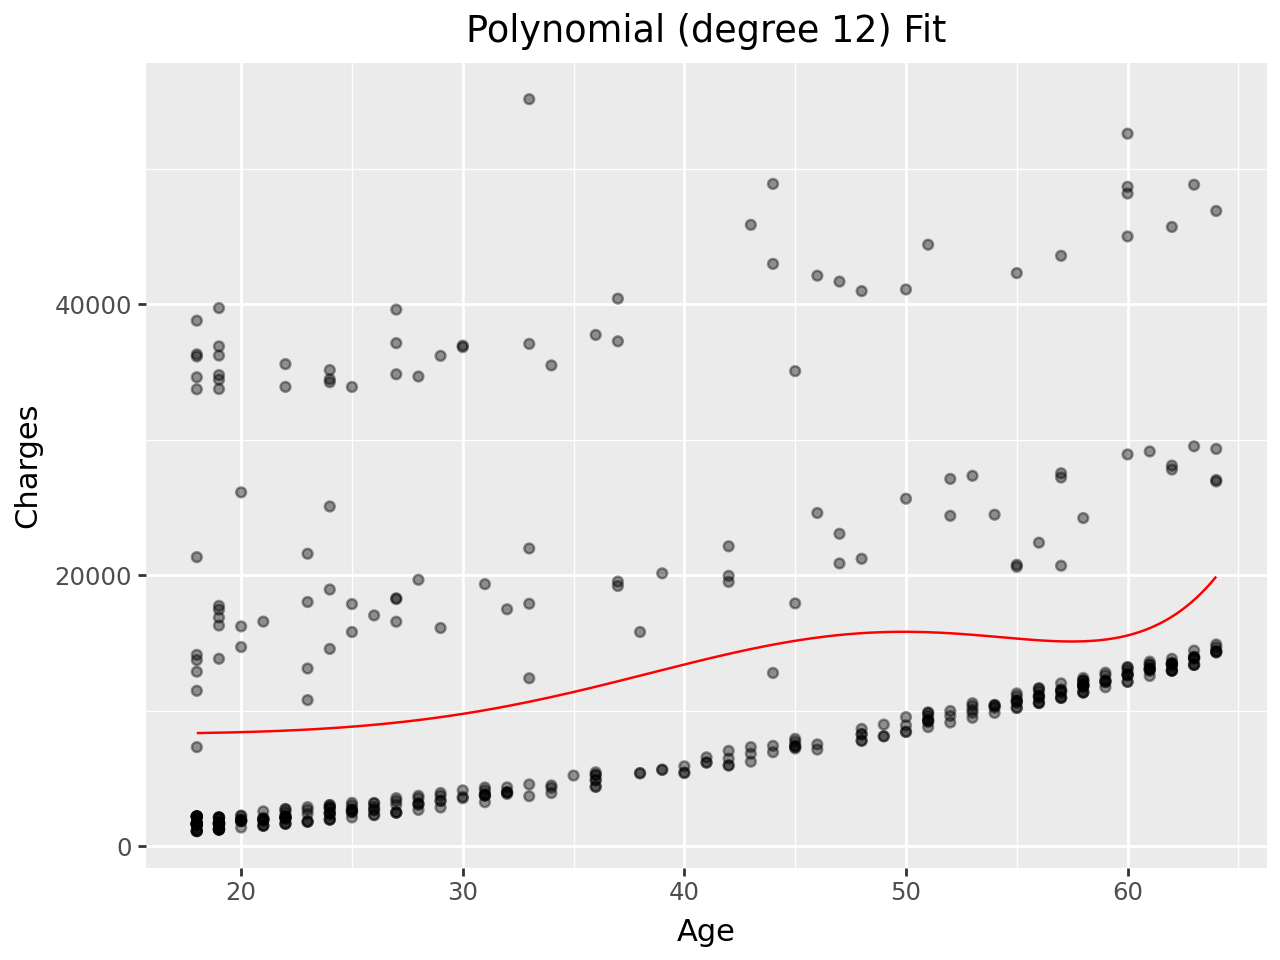

In [136]:
p_poly.show()

# Part Four: New data

Model: age, age + bmi, age + bmi + smoker, (age + bmi):smoker, (age + bmi)*smoker

In [137]:
url2 = "https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1"
new = pd.read_csv(url2)

print(new.head())

   age     sex     bmi smoker     region      charges
0   23    male  34.400     no  southwest   1826.84300
1   56    male  40.300     no  southwest  10602.38500
2   18    male  34.100     no  southeast   1137.01100
3   63  female  23.085     no  northeast  14451.83515
4   63    male  28.310     no  northwest  13770.09790


In [138]:
print(new.dtypes)

age          int64
sex         object
bmi        float64
smoker      object
region      object
charges    float64
dtype: object


In [139]:
print(new.describe())


              age         bmi       charges
count  143.000000  143.000000    143.000000
mean    39.902098   29.891434  12573.571373
std     16.624822    5.786784  12495.668607
min     18.000000   18.600000   1121.873900
25%     21.500000   25.477500   3072.870450
50%     42.000000   29.300000   9634.538000
75%     56.000000   33.495000  14269.826100
max     64.000000   53.130000  63770.428010


In [140]:
print(new.nunique())

age         45
sex          2
bmi        127
smoker       2
region       4
charges    143
dtype: int64


In [141]:
print(len(new))
new = new.dropna()
print(len(new))

143
143


In [142]:
def mse_r2(pipe, X_cols):
    pipe.fit(df[X_cols], y)
    preds = pipe.predict(new[X_cols])
    return mean_squared_error(new["charges"], preds), r2_score(new["charges"], preds)


In [143]:
results = {}

In [144]:
pipe_simple = Pipeline([("lr", LinearRegression())])
results["age"] = mse_r2(pipe_simple, ["age"])
results["age+bmi"] = mse_r2(pipe_simple, ["age","bmi"])


In [145]:
ct_smoker = ColumnTransformer([
    ("num","passthrough",["age","bmi"]),
    ("cat",OneHotEncoder(drop="first"),["smoker"])
])
pipe_smoker = Pipeline([("ct",ct_smoker),("lr",LinearRegression())])
results["age+bmi+smoker"] = mse_r2(pipe_smoker, ["age","bmi","smoker"])


In [146]:
def add_smoker_indicator(frame):
    # Ensure smoker is binary 0/1 where 1 == "yes"
    s = (frame["smoker"].astype(str).str.lower() == "yes").astype(int)
    return s

In [147]:
def design_matrix(frame, spec):
    X = pd.DataFrame(index=frame.index)
    smk = add_smoker_indicator(frame)

    if spec in ["age", "age+bmi", "age+bmi+smoker", "(age+bmi):smoker", "(age+bmi)*smoker"]:
        # always include age / bmi if asked
        if "age" in spec:
            X["age"] = frame["age"]
        if "bmi" in spec:
            X["bmi"] = frame["bmi"]
        # interactions only
        if spec == "(age+bmi):smoker":
            X["age_x_smk"] = frame["age"] * smk
            X["bmi_x_smk"] = frame["bmi"] * smk
        # main + interactions
        if spec == "(age+bmi)*smoker":
            X["smoker_yes"] = smk
            X["age_x_smk"] = frame["age"] * smk
            X["bmi_x_smk"] = frame["bmi"] * smk
        # add smoker main ONLY for the "+smoker" (no interactions) case
        if spec == "age+bmi+smoker":
            X["smoker_yes"] = smk
    else:
        raise ValueError("Unknown spec")

    return X

In [148]:
def fit_on_old_predict_on_new(spec):
    # Build X for train (df) and test (new) according to spec
    X_train = design_matrix(df, spec)
    X_test = design_matrix(new, spec)

    # Align any possible column order differences (safe-guard)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    lr = LinearRegression().fit(X_train, y)
    preds = lr.predict(X_test)

    mse = mean_squared_error(new["charges"], preds)
    r2  = r2_score(new["charges"], preds)
    return mse, r2, lr

In [149]:
specs = [
    "age",
    "age+bmi",
    "age+bmi+smoker",
    "(age+bmi):smoker",
    "(age+bmi)*smoker",
]

In [150]:
res_p4 = {}
for sp in specs:
    mse, r2, _ = fit_on_old_predict_on_new(sp)
    res_p4[sp] = (mse, r2)
    print(f"{sp} -> MSE={mse}, R²={r2}")

age -> MSE=136077136.50195494, R²=0.12236515675533055
age+bmi -> MSE=132636406.1108129, R²=0.14455628272331222
age+bmi+smoker -> MSE=35377541.24141631, R²=0.7718311565047801
(age+bmi):smoker -> MSE=24795908.41264335, R²=0.8400778135676982
(age+bmi)*smoker -> MSE=21786256.86685262, R²=0.8594886795699613


In [151]:
best_spec_p4 = "(age+bmi)*smoker"


In [152]:
# Fit on original, predict on new, compute residuals
X_trainain_p4 = design_matrix(df, best_spec_p4)
X_testst_p4  = design_matrix(new, best_spec_p4).reindex(columns=X_trainain_p4.columns, fill_value=0)

lr_p4 = LinearRegression().fit(X_trainain_p4, y)
new_pred_p4 = lr_p4.predict(X_testst_p4)
new_resid_p4 = new["charges"] - new_pred_p4



In [153]:
resid_df_p4 = pd.DataFrame({
    "fitted": new_pred_p4,
    "residuals": new_resid_p4
})

print(resid_df_p4)

           fitted     residuals
0     3597.873351  -1771.030351
1    12149.436734  -1547.051734
2     2305.366140  -1168.355140
3    13864.402577    587.432573
4    13892.414696   -122.316796
..            ...           ...
138  33030.205316   1798.448684
139  32670.261048  29922.612042
140  28373.298919   9456.425281
141   3820.240500  -1355.621700
142   2407.389227  -1243.926527

[143 rows x 2 columns]


In [154]:
p_resid_p4 = (
    p9.ggplot(resid_df_p4, p9.aes(x="fitted", y="residuals")) +
    p9.geom_point(alpha=0.5) +
    p9.geom_hline(yintercept=0, linetype="dashed") +
    p9.labs(
        title=f"Residuals vs Fitted (Part 4 final model: {best_spec_p4})",
        x="Fitted values",
        y="Residuals"
    )
)

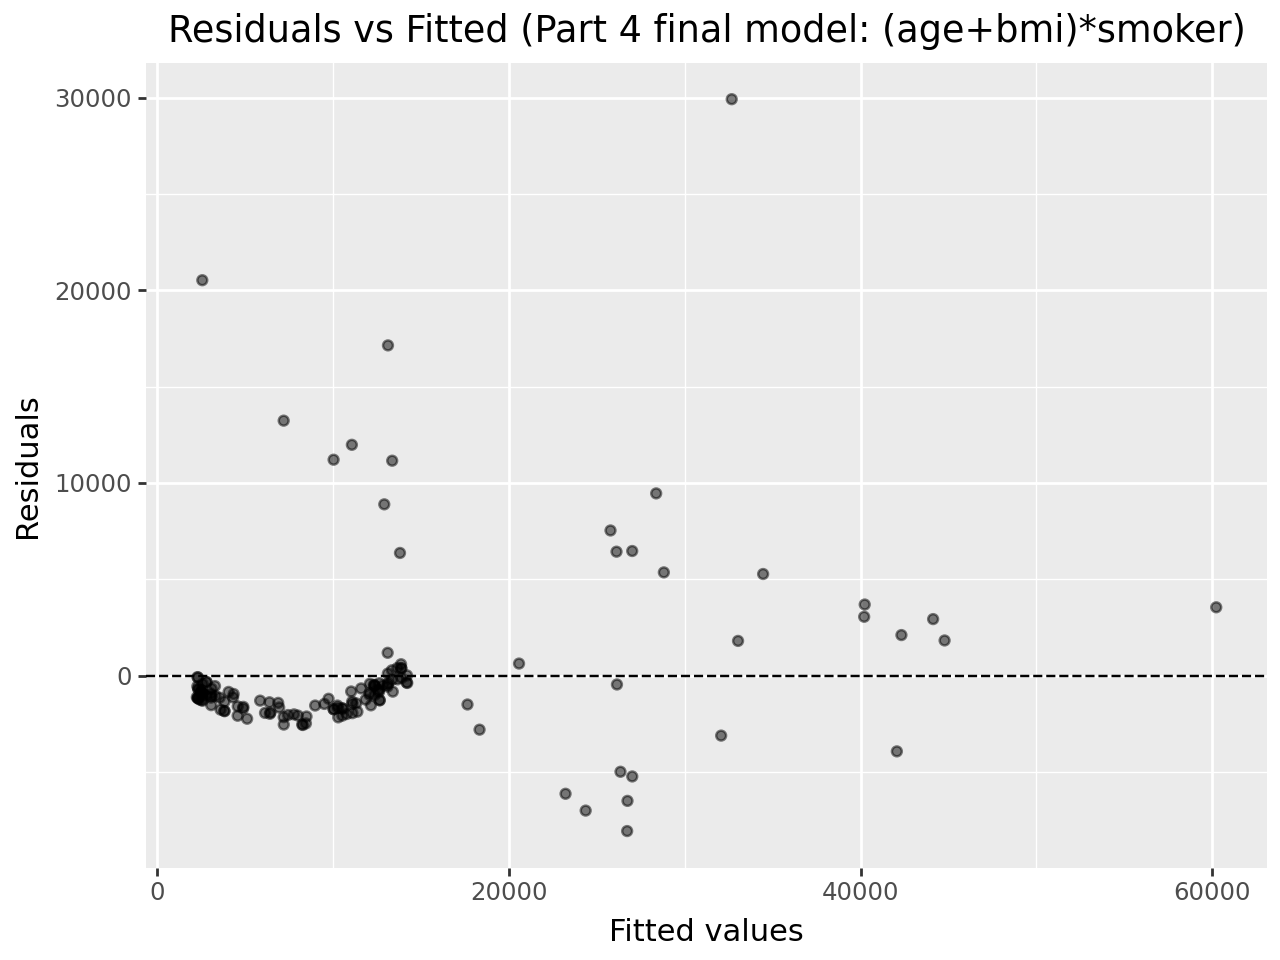

In [155]:
p_resid_p4.show()


# Part Five: Full Exploration

Model: $age + bmi + smoker + sex, log(charges) ~ age + bmi + smoker + sex, charges ~ age^3 + bmi^3 + smoker + sex$

In [156]:
num = ["age", "bmi"]
cat = ["smoker", "sex"]
X_cols = num + cat

In [157]:
X_train = df[X_cols]
X_test = new[X_cols]
y_train = df["charges"].values
y_test = new["charges"].values

In [158]:
def fit_score(pipe, name, post=None):
    """Fits on old data, predicts on new, computes MSE/R²."""
    pipe.fit(X_train, y_train if post is None else np.log(y_train))
    pred = pipe.predict(X_test)
    if post is not None:
        pred = post(pred)        # e.g. exp() for log model
    mse = mean_squared_error(y_test, pred)
    r2  = r2_score(y_test, pred)
    print(f"{name}: MSE={mse}, R²={r2}")
    return name, mse, r2, pred

In [159]:
# Model 1: Linear (age, bmi, smoker, sex) 
ct_linear = ColumnTransformer([
    ("num", "passthrough", num),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat)
])
m1 = Pipeline([("ct", ct_linear), ("lr", LinearRegression())])

In [160]:
# Model 2: Log-transform target
# Fit model on log(charges), then back-transform with exp
m2 = Pipeline([("ct", ct_linear), ("lr", LinearRegression())])

In [161]:
#Model 3: Polynomial (degree = 3)
ct_poly = ColumnTransformer([
    ("num", Pipeline([
        ("sc", StandardScaler()),
        ("poly", PolynomialFeatures(degree=3, include_bias=False))
    ]), num),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat)
])
m3 = Pipeline([("ct", ct_poly), ("lr", LinearRegression())])

In [162]:
results = []
results.append(fit_score(m1, "Model 1: Linear"))
results.append(fit_score(m2, "Model 2: Log-Target", post=np.exp))
results.append(fit_score(m3, "Model 3: Polynomial (deg=3)"))

Model 1: Linear: MSE=35467887.905617885, R²=0.7712484621410353
Model 2: Log-Target: MSE=84669352.52495237, R²=0.453921681179728
Model 3: Polynomial (deg=3): MSE=36284029.2537837, R²=0.76598472642043


Model 1 — Linear regression with age, bmi, smoker, and sex.
Lowest MSE, highest R².

In [163]:
pred_best = m1.predict(X_test)
residuals = y_test - pred_best

resid_df = pd.DataFrame({
    "fitted": pred_best,
    "residuals": residuals
})

In [164]:
p_resid_best = (
    p9.ggplot(resid_df, p9.aes(x="fitted", y="residuals")) +
    p9.geom_point(alpha=0.5) +
    p9.geom_hline(yintercept=0, linetype="dashed", color="black") +
    p9.labs(
        title="Residuals vs Fitted — Model 1: Linear (age, bmi, smoker, sex)",
        x="Fitted Values",
        y="Residuals"
    ) 
    )

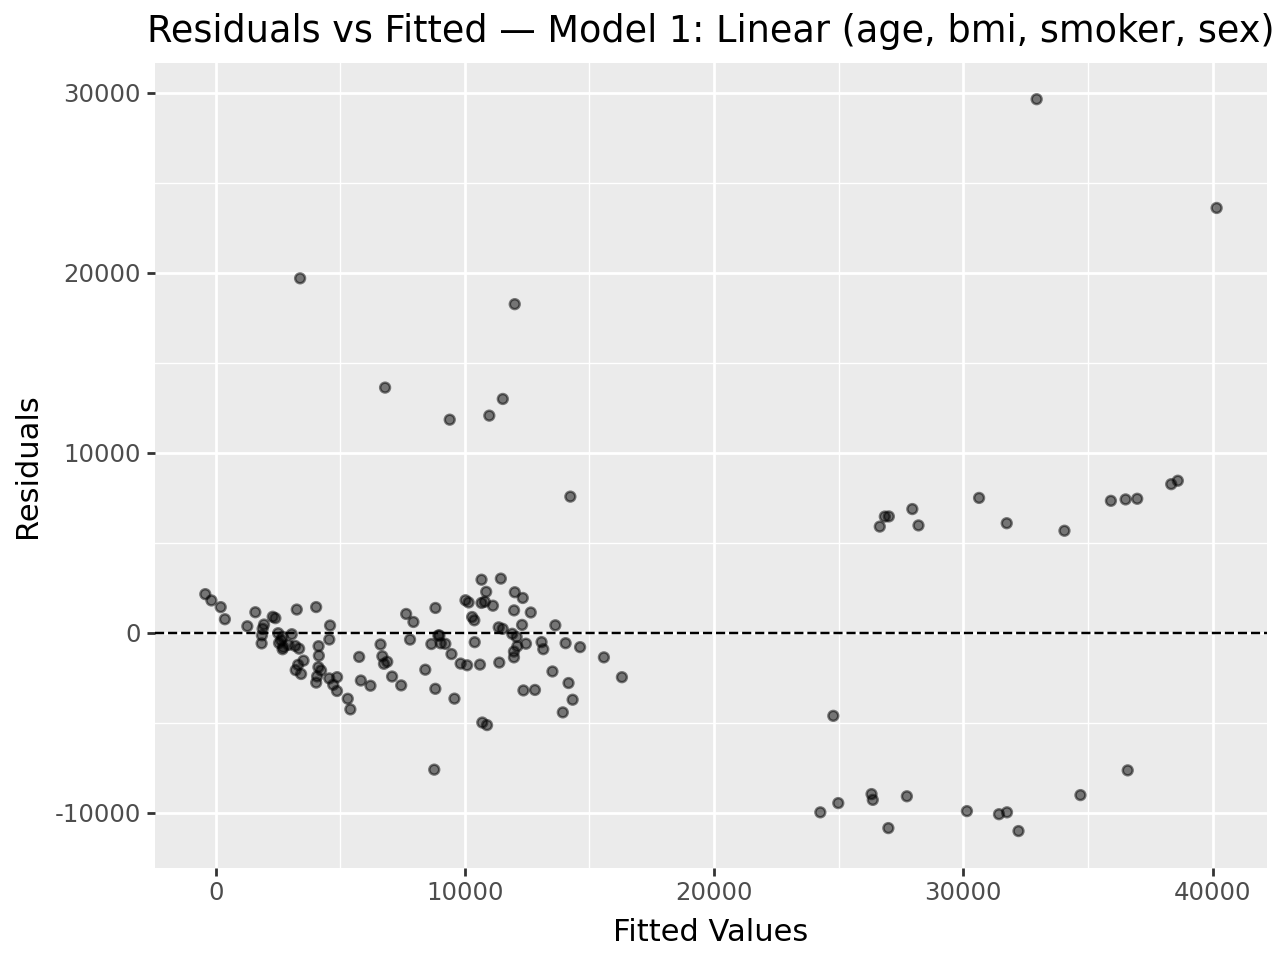

In [165]:
p_resid_best.show()